In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import sys
sys.path.append('/content/gdrive/MyDrive/PrimeVisionProj')

In [3]:
%cd /content/gdrive/MyDrive/PrimeVisionProj
!ls

/content/gdrive/MyDrive/PrimeVisionProj
astar.py	   Floorplans	      lightning_logs	SPPdynamicenv.py  SPPv2env.py
exploration.ipynb  Floorplan_Testing  pdp.ipynb		SPPembeddings.py  tsp.ipynb
Floorplan_Codes    FPenv.py	      PlotFloorplan.py	SPPenv.py	  utils.py


In [4]:
!pip install rl4co==0.3.3
!pip install torch==2.3.0
!pip install matplotlib==3.8.4

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/usr/local/lib/python3.10/dist-packages/matplotlib-3.7.1.dist-info/METADATA'



/usr/local/lib/python3.10/dist-packages/lightning/fabric/__init__.py:41: Deprecated call to `pkg_resources.declare_namespace('lightning.fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2349: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(parent)
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/__init__.py:37: Deprecated call to `pkg_resources.declare_namespace('lightning.pytorch')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resourc

tensor([-12., -40., -14.])


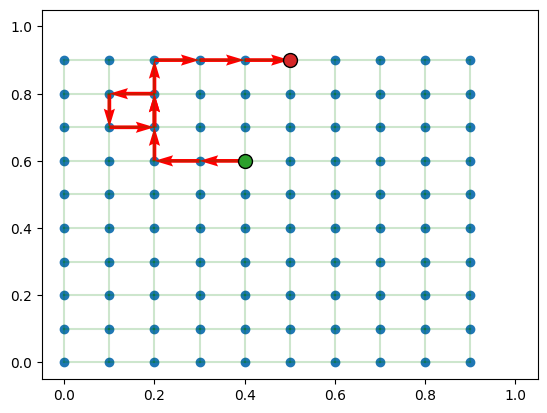

In [5]:
from SPPenv import SPPEnv
from utils import rollout, random_policy

batch_size = 3

env = SPPEnv(num_loc=100)
reward, td, actions = rollout(env, env.reset(batch_size=batch_size), random_policy)
print(reward)
env.render(td, actions)

In [6]:
from astar import AStarSearch
from SPPenv import SPPEnv
import torch

env = SPPEnv(num_loc=100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
astar = AStarSearch(td_init)
actions_astar = astar.search()
print(actions_astar)

{'actions': tensor([[90, 80, 70, 60, 61, 62, 63, 64, 65, 66, 67, 68],
        [33, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32],
        [ 5,  6,  7,  8,  9, 19, 29, 39, 49, 59, 69, 79]]), 'reward': tensor([-11.,  -1., -11.])}


In [7]:
from SPPembeddings import SPPInitEmbedding, SPPContext, StaticEmbedding
from rl4co.models.zoo import AttentionModel, AutoregressivePolicy, POMO, POMOPolicy

env = SPPEnv(num_loc=100)

# from SPPv2env import SPPv2Env
# env = SPPv2Env(num_loc=100)

# Instantiate policy with the embeddings we created above
emb_dim = 64
policy = AutoregressivePolicy(env,
                              embedding_dim=emb_dim,
                              init_embedding=SPPInitEmbedding(emb_dim),
                              context_embedding=SPPContext(emb_dim),
                              dynamic_embedding=StaticEmbedding(emb_dim)
)

# policy = POMOPolicy(env,
#                     embedding_dim=emb_dim,
#                     init_embedding=SPPInitEmbedding(emb_dim),
#                     context_embedding=SPPContext(emb_dim),
#                     dynamic_embedding=StaticEmbedding(emb_dim))

# model = POMO(env, policy=policy,
#                   baseline='shared',
#                   batch_size=3,
#                   train_data_size=100,
#                   val_data_size=100,)

# Model: default is AM with REINFORCE and greedy rollout baseline
model = AttentionModel(env,
                       policy=policy,
                       baseline='rollout',
                       train_data_size=100_00,
                       val_data_size=100_0,)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


Problem 1 | Cost: 1000.000
Problem 2 | Cost: 1000.000
Problem 3 | Cost: 2.000


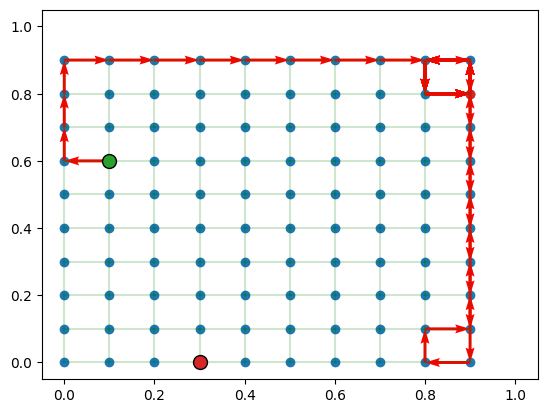

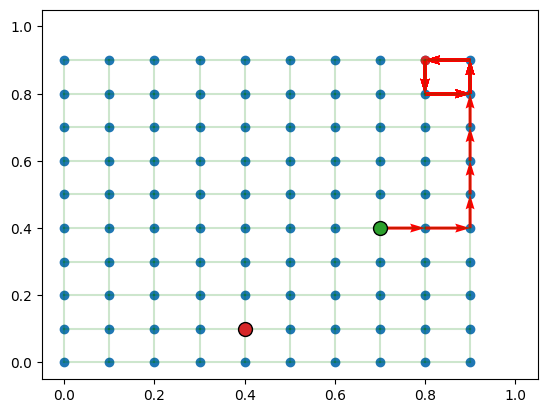

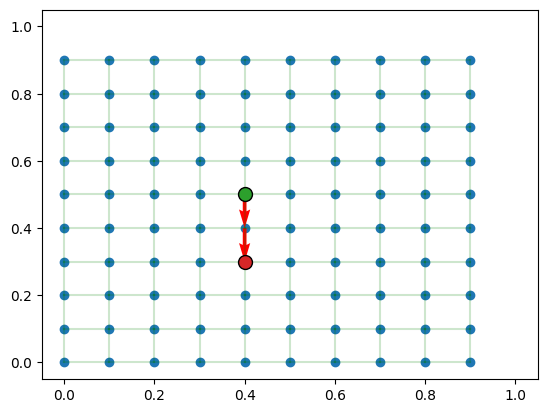

In [8]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
td_init = env.reset(batch_size=[3]).to(device)
model = model.to(device)
out = model(td_init.clone(), phase="test", decode_type="greedy", return_actions=True)
actions_untrained = out["actions"].cpu().detach()
rewards_untrained = out["reward"].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_init[i], actions_untrained[i])

In [9]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None
)

trainer.fit(model)


INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                 | Params | Mode 
----------------------------------------------------------
0 | env      | SPPEnv               | 0      | train
1 | policy   | AutoregressivePolicy | 278 K  | train
2 | baseline | WarmupBaseline       | 278 K  | train
----------------------------------------------------------
556 K     Trainable params
0         Non-trainable params
556 K     Total params
2.225     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name     | Type   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=3` reached.


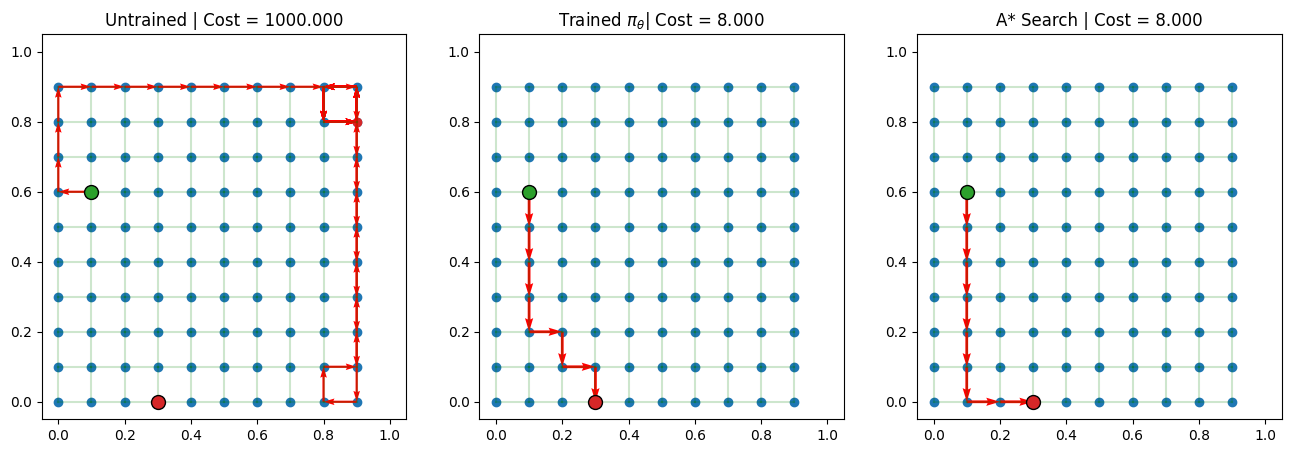

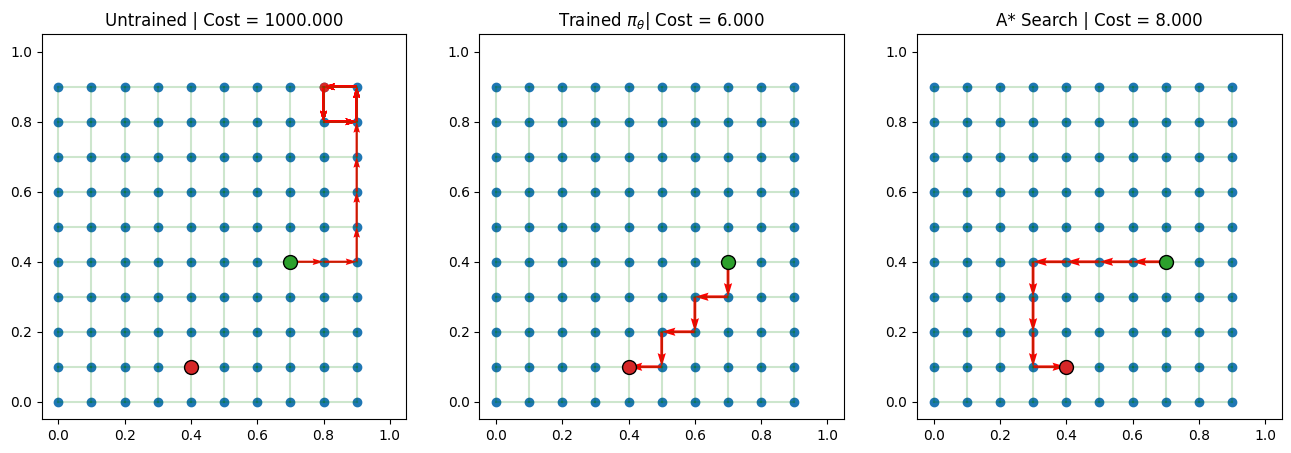

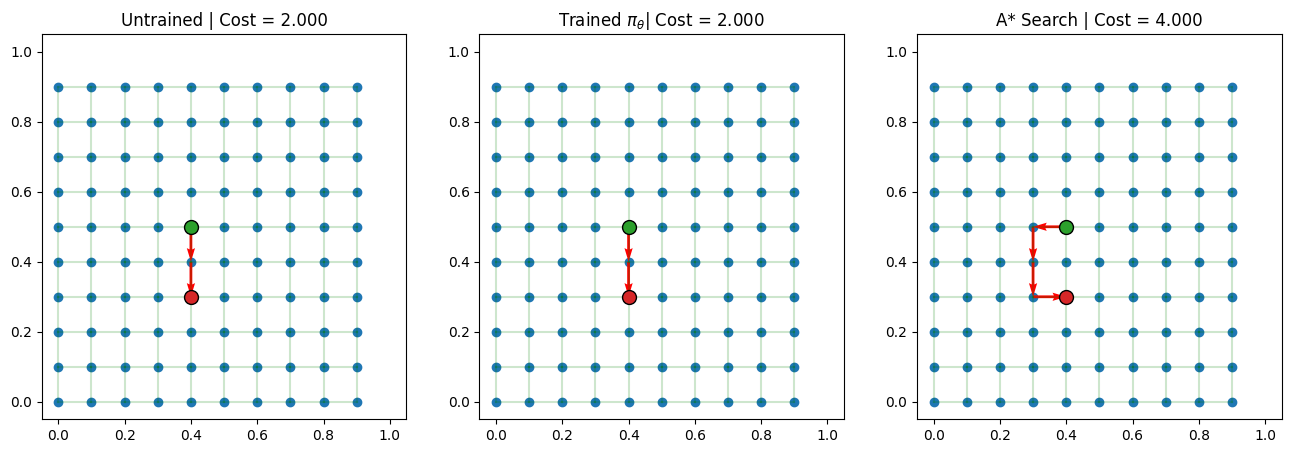

In [10]:
# infer_env = SPPEnv(num_loc=500)
#from SPPenv import SPPEnv
#infer_env = SPPDynamicEnv(num_loc=100)
# infer_env = SPPEnv(num_loc=100)

# td_init = env.reset(batch_size=[3]).to(device)

# model = model.to(device)
# out = model(td_init.clone(),env=env, phase="test", decode_type="greedy",
# return_actions=True)
# actions_trained = out['actions'].cpu().detach()

policy = model.policy.to(device)
out = policy(td_init.clone(), env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,3, figsize=(16,5))
    env.render(td, actions_untrained[i], ax=axs[0])
    axs[0].set_title(f"Untrained | Cost = {-rewards_untrained[i].item():.3f}")

    env.render(td, actions_trained[i], ax=axs[1])
    axs[1].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    env.render(td, actions_astar[i], ax=axs[2])
    axs[2].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))

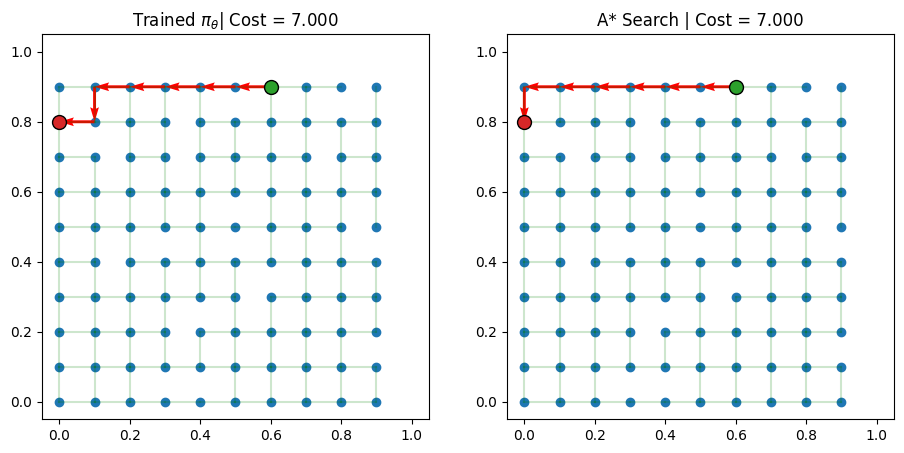

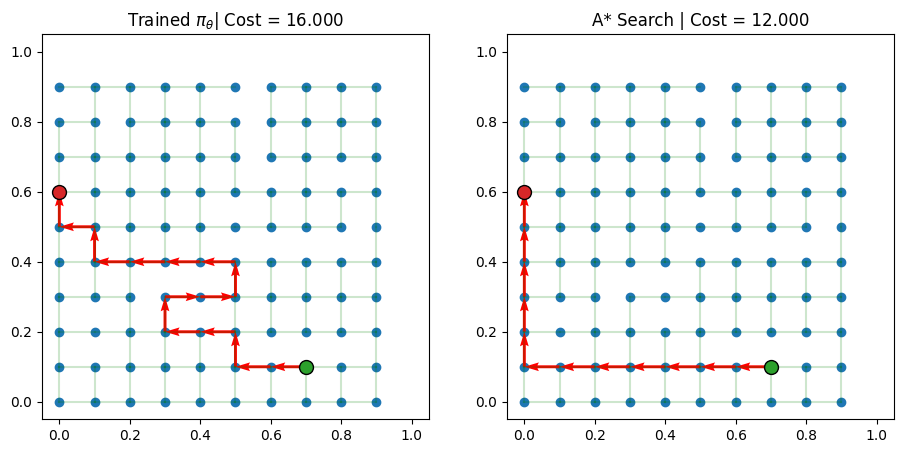

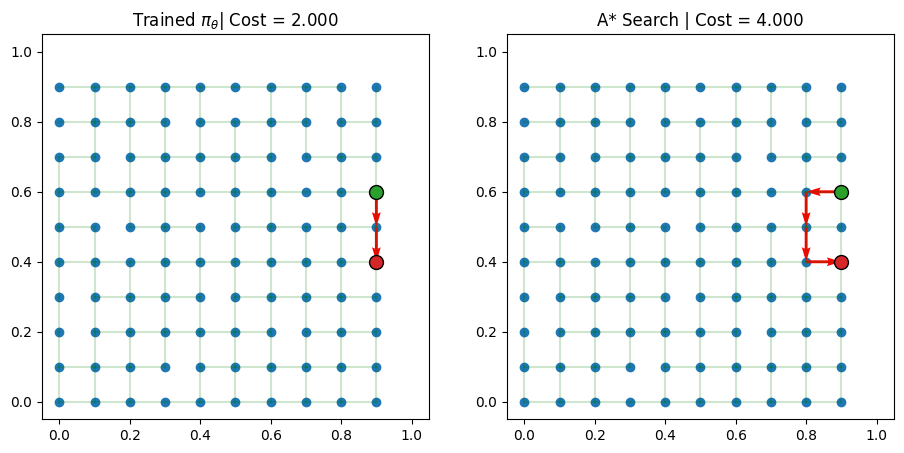

In [11]:
from SPPv2env import SPPv2Env

infer_env = SPPv2Env(num_loc=100)
td_init = infer_env.reset(batch_size=[3]).to(device)

policy = model.policy.to(device)
out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))

In [ ]:
import numpy as np
# Initialize the total costs
total_cost_trained = 0
total_cost_astar = 0
cost_list_trained = np.array([])
cost_list_astar = np.array([])

# Number of runs
num_runs = 100

batch_size = 10

# Initialize the action lists
actions_trained = []
actions_astar = []

# Initialize the TensorDict list
td_list = []

for _ in range(num_runs):
    while True:
        try:
            # Initialize the action lists for the current run
            actions_trained_run = []
            actions_astar_run = []

            # infer_env = SPPEnv(num_loc=100)
            # td_init = infer_env.reset(batch_size=[batch_size]).to(device)

            infer_env = SPPv2Env(num_loc=100)
            td_init = infer_env.reset(batch_size=[batch_size]).to(device)

            # Run the trained DRL model
            out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
            total_cost_trained += out['reward'].sum().item()

            # Run A* search
            astar = AStarSearch(td_init.clone())
            astar_out = astar.search()
            total_cost_astar += astar_out["reward"].sum().item()

            # Store the TensorDict
            td_list.append(td_init)

            # Store the output of the astar and trained model
            actions_trained.append(out["actions"].cpu().detach())
            actions_astar.append(astar_out["actions"].cpu().detach())

            # Store the cost of the trained model and A* search
            cost_list_trained = np.append(cost_list_trained, out["reward"].cpu().detach().numpy())
            cost_list_astar = np.append(cost_list_astar, astar_out["reward"].cpu().detach().numpy())

            break
        except:
            continue

    # Append the action lists for the current run to the overall action list
    # actions_trained.append(actions_trained_run)
    # actions_astar.append(actions_astar_run)

# How many -1000 rewards are there in the trained DRL model
nosols_trained = np.sum(cost_list_trained == -1000)
print(f"Number of unsolved problems in trained DRL model: {nosols_trained}")

# Remove all the -1000 rewards
cost_list_trained_filtered = cost_list_trained[cost_list_trained != -1000]

Number of unsolved problems in trained DRL model: 28


Mean cost of trained DRL model over 1000 runs: -6.930
Mean cost of A* search over 1000 runs: -7.404
Median cost of trained DRL model over 1000 runs: -7.000
Median cost of A* search over 1000 runs: -7.000
Standard deviation of trained DRL model over 1000 runs: 3.431
Standard deviation of A* search over 1000 runs: 3.666


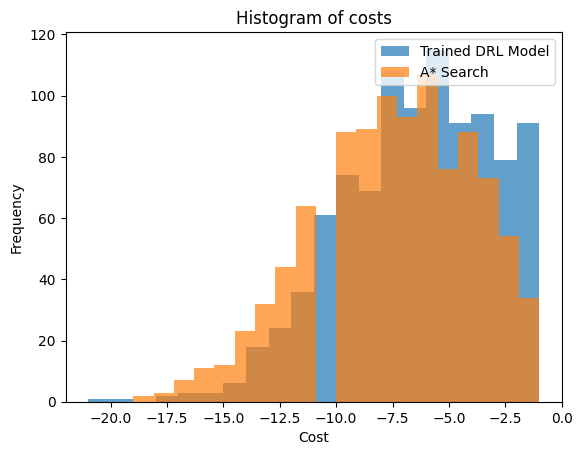

[620 683 210]
[-18. -19. -19.]
62 0
68 3
21 0
[247 513   7]
24 7
51 3
0 7


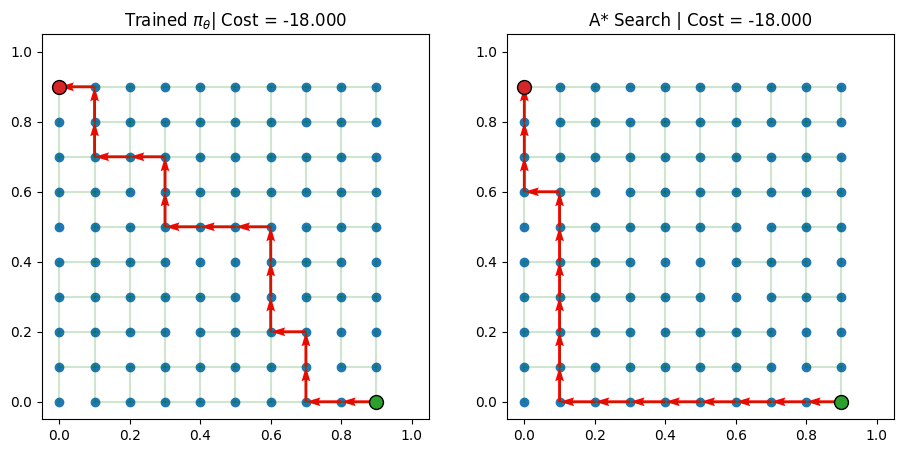

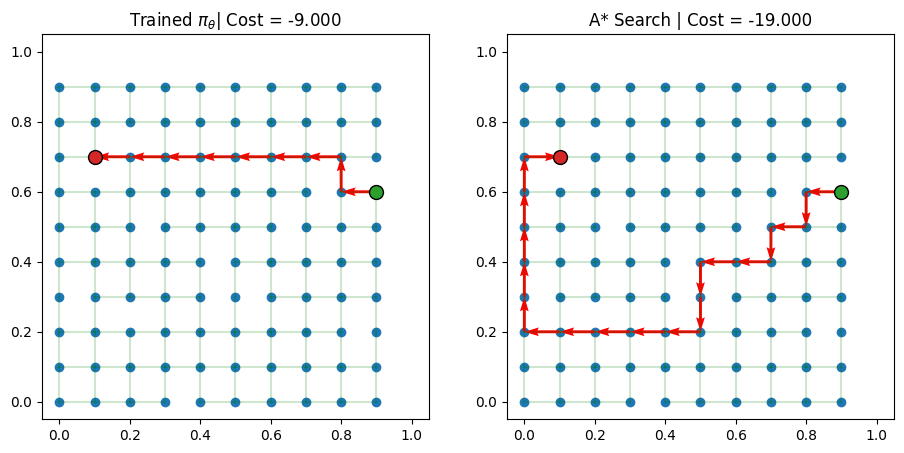

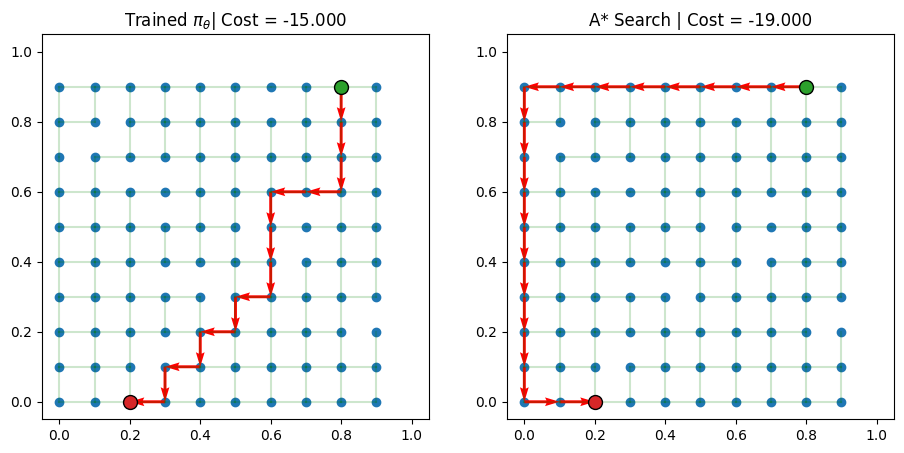

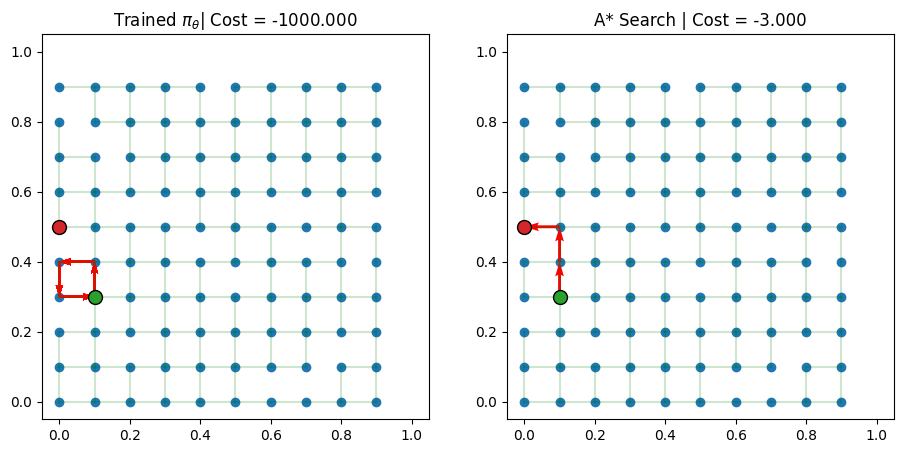

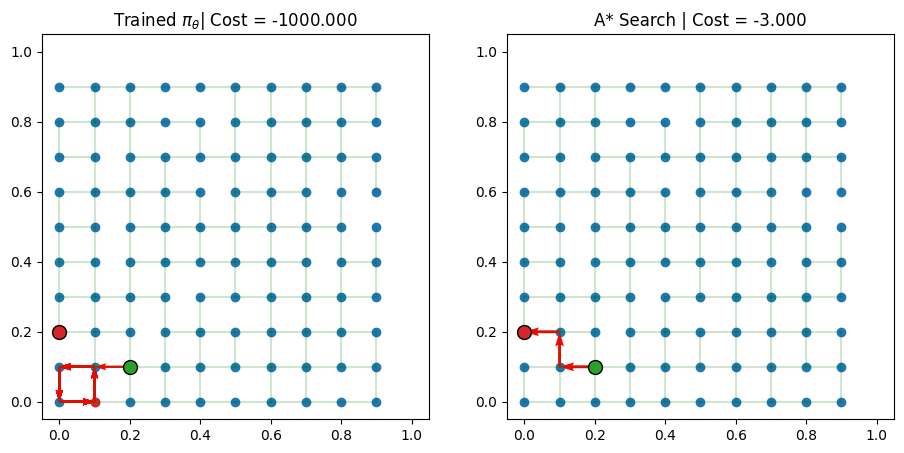

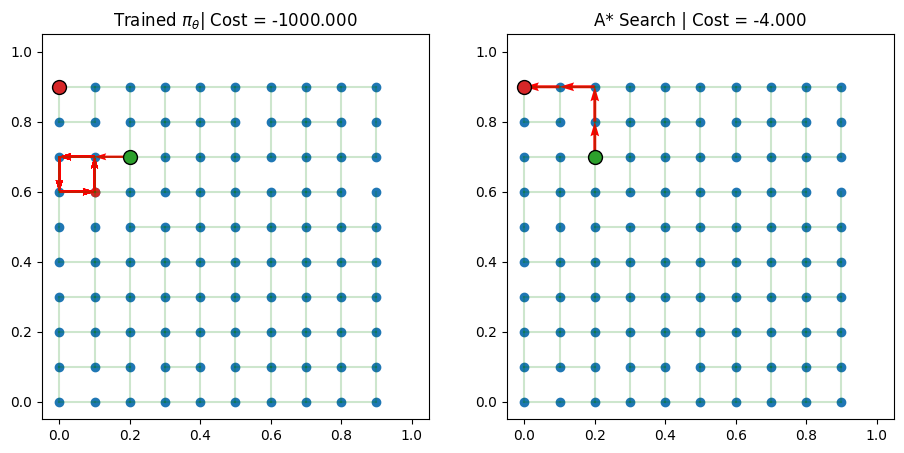

In [ ]:
# Calculate the average costs
print ("Mean cost of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_trained_filtered.mean()))
print ("Mean cost of A* search over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_astar.mean()))

# Calculate the mean and standard deviation of the costs
print ("Median cost of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, np.median(cost_list_trained_filtered)))
print ("Median cost of A* search over {} runs: {:.3f}".format(num_runs * batch_size, np.median(cost_list_astar)))
print ("Standard deviation of trained DRL model over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_trained_filtered.std()))
print ("Standard deviation of A* search over {} runs: {:.3f}".format(num_runs * batch_size, cost_list_astar.std()))

# Plot the histogram of the costs
plt.hist(cost_list_trained_filtered, bins=20, alpha=0.7, label='Trained DRL Model')
plt.hist(cost_list_astar, bins=20, alpha=0.7, label='A* Search')
plt.legend(loc='upper right')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.title('Histogram of costs')
plt.show()

# Get the indices of the runs with the highest costs
worst_runs = np.argsort(cost_list_astar)[::-1][-3:]
print(worst_runs)
print(cost_list_astar[worst_runs])

# Plot the actions for the first run
import matplotlib.pyplot as plt

for run in worst_runs:
    quotient, remainder = divmod(run, batch_size)
    print(quotient, remainder)
    for i, td in enumerate(td_list[quotient]):
        if i == remainder:
            fig, axs = plt.subplots(1,2, figsize=(11,5))

            try:
                infer_env.render(td, actions_trained[quotient][i], ax=axs[0])
                axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {cost_list_trained[run]:.3f}")
            except Exception as e:
                print(e)
                print("Error in plotting trained model")
                pass

            infer_env.render(td, actions_astar[quotient][i], ax=axs[1])
            axs[1].set_title("A* Search | Cost = {:.3f}".format(cost_list_astar[run]))

# Plot the actions with the largest difference between the trained model and A* search
diff = - cost_list_trained + cost_list_astar
largest_diffs = np.argsort(diff)[::-1][:3]
print(largest_diffs)

for run in largest_diffs:
    quotient, remainder = divmod(run, batch_size)
    print(quotient, remainder)
    for i, td in enumerate(td_list[quotient]):
        if i == remainder:
            fig, axs = plt.subplots(1,2, figsize=(11,5))

            try:
                infer_env.render(td, actions_trained[quotient][i], ax=axs[0])
                axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {cost_list_trained[run]:.3f}")
            except Exception as e:
                print(e)
                print("Error in plotting trained model")
                pass

            infer_env.render(td, actions_astar[quotient][i], ax=axs[1])
            axs[1].set_title("A* Search | Cost = {:.3f}".format(cost_list_astar[run]))

# Real Floorplan Path Finding

## Astar Search

num_loc: 58
Row Length: 58
Column Length: 58
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0

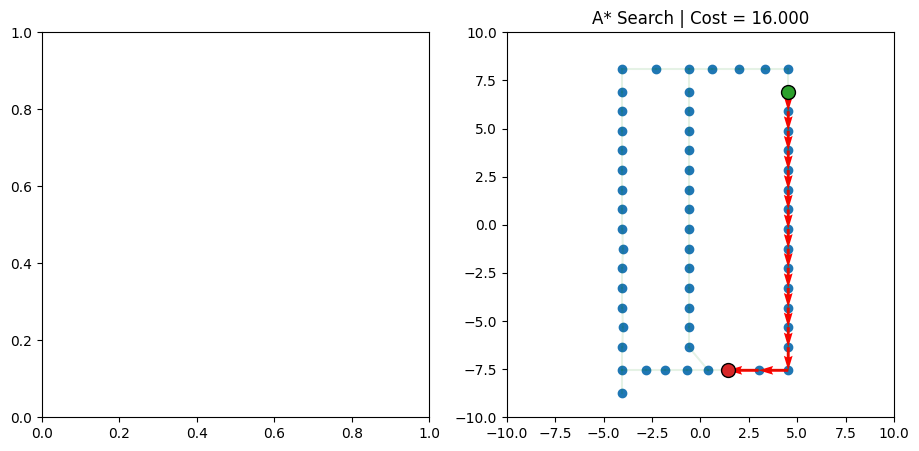

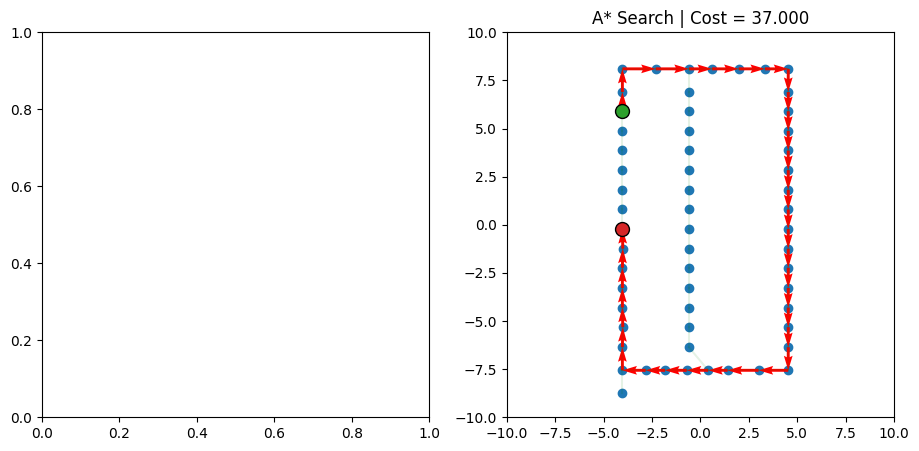

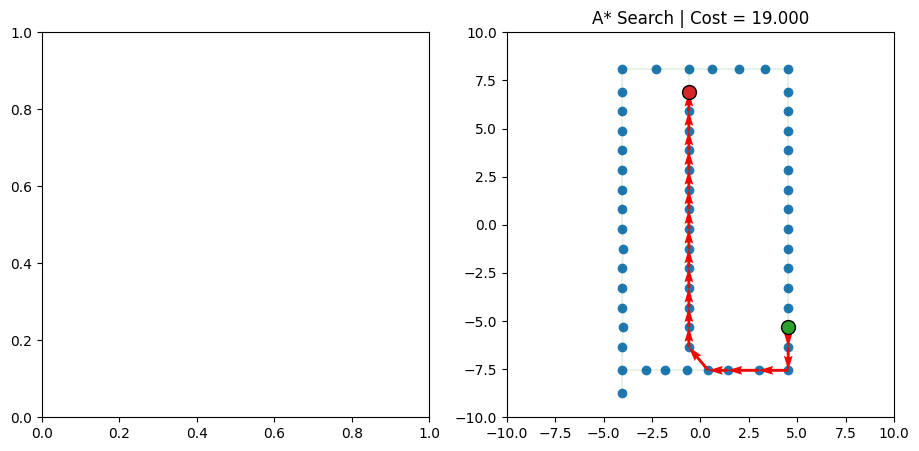

In [17]:
from FPenv import FPEnv
from astar import AStarSearch
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

infer_env = FPEnv(fp_path="Floorplan_Testing/floorplan_SLC.json")
td_init = infer_env.reset(batch_size=[3]).to(device)

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_astar[i], ax=axs[1])
    axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))


# Reinforcement Learning

num_loc: 58
Row Length: 58
Column Length: 58
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0

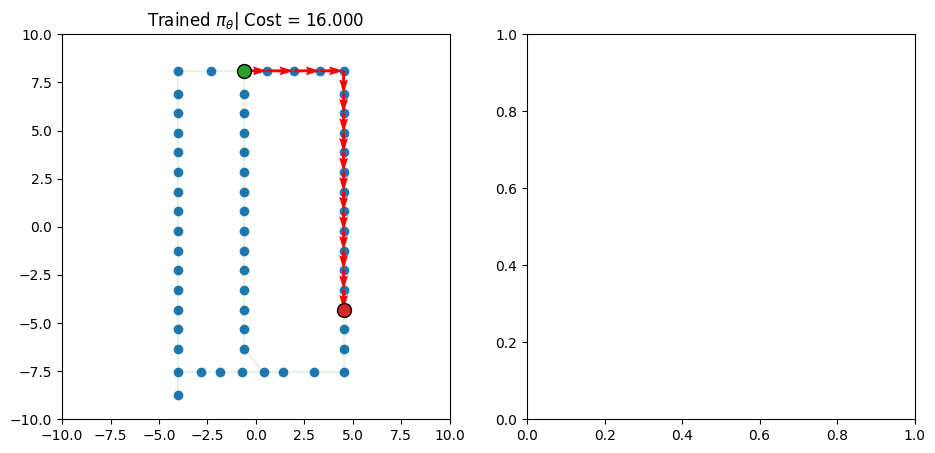

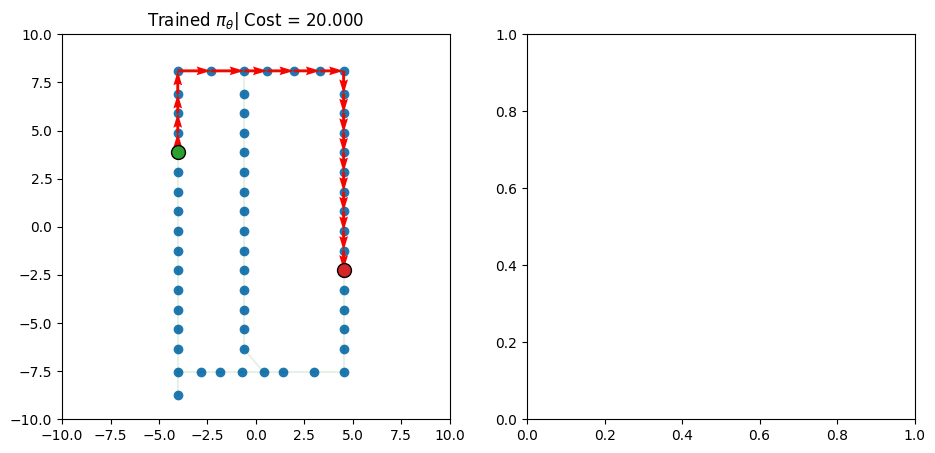

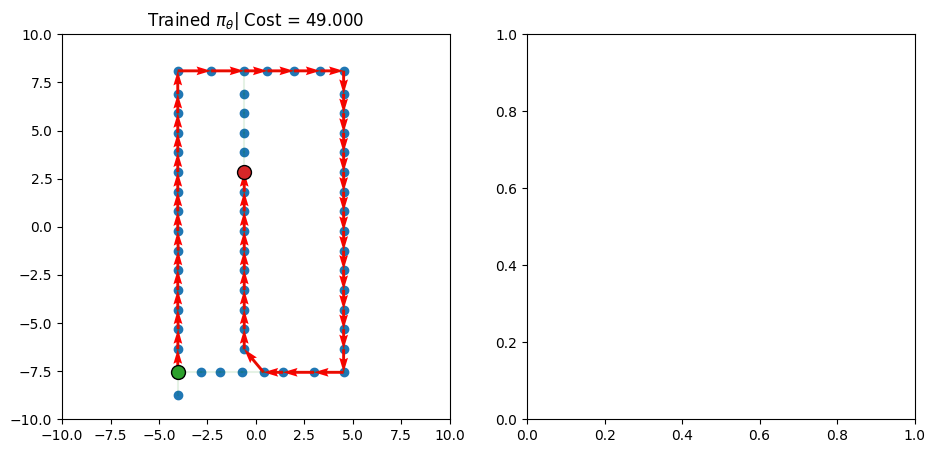

In [16]:
from FPenv import FPEnv
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

infer_env = FPEnv(fp_path="Floorplan_Testing/floorplan_SLC.json")
td_init = infer_env.reset(batch_size=[3]).to(device)


# Function to check for NaNs in a tensor dictionary
nan_found = False
for key, tensor in td_init.items():
  if torch.isnan(tensor).any():
    nan_found = True
    print(f"NaN values found in tensor '{key}'")
if not nan_found:
  print("No NaN values found in the tensor dictionary.")


# # Instantiate policy with the embeddings we created above
# emb_dim = 64
# policy = AutoregressivePolicy(env,
#                               embedding_dim=emb_dim,
#                               init_embedding=SPPInitEmbedding(emb_dim),
#                               context_embedding=SPPContext(emb_dim),
#                               dynamic_embedding=StaticEmbedding(emb_dim)
# )

# # Model: default is AM with REINFORCE and greedy rollout baseline
# model = AttentionModel(infer_env,
#                        policy=policy,
#                        baseline='rollout',
#                        train_data_size=100_00,
#                        val_data_size=100_0,)

# model = model.to(device)
policy = model.policy.to(device)

out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
    fig, axs = plt.subplots(1,2, figsize=(11,5))

    infer_env.render(td, actions_trained[i], ax=axs[0])
    axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")


num_loc: 58
Row Length: 58
Column Length: 58
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0

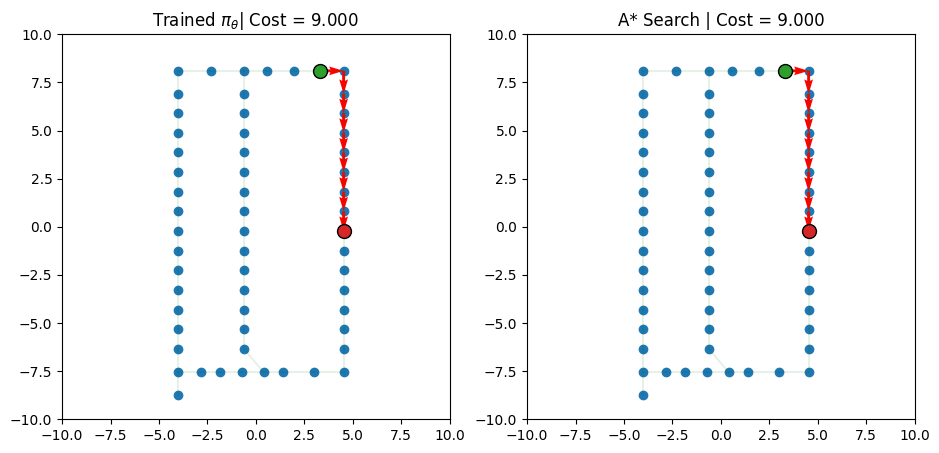

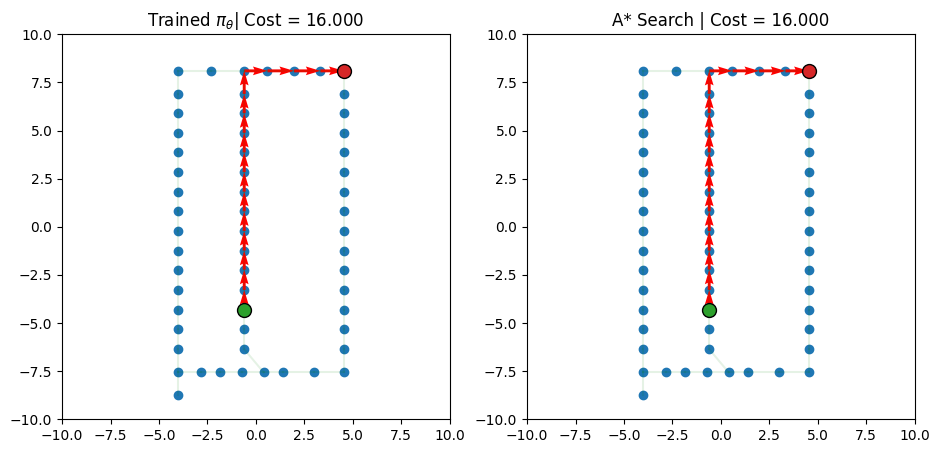

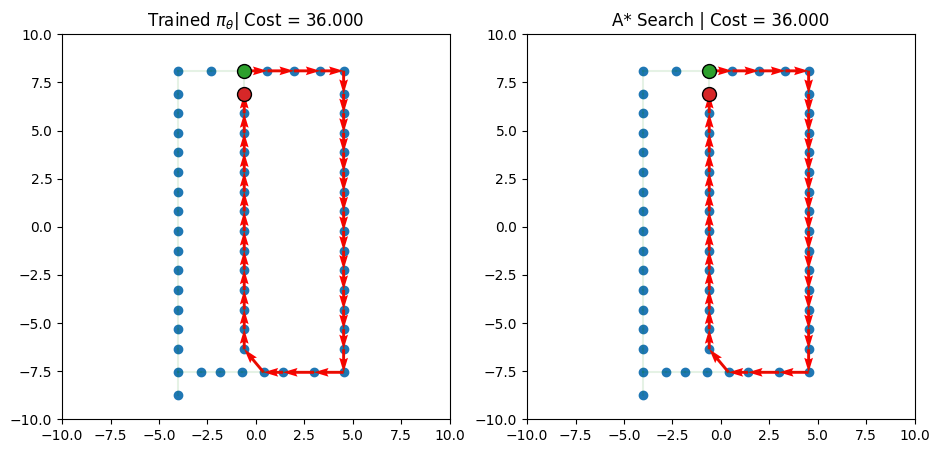

In [20]:
from FPenv import FPEnv
from astar import AStarSearch
import torch

# Setup a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

infer_env = FPEnv(fp_path="Floorplan_Testing/floorplan_SLC.json")
td_init = infer_env.reset(batch_size=[3]).to(device)


# Function to check for NaNs in a tensor dictionary
nan_found = False
for key, tensor in td_init.items():
  if torch.isnan(tensor).any():
    nan_found = True
    print(f"NaN values found in tensor '{key}'")
if not nan_found:
  print("No NaN values found in the tensor dictionary.")

policy = model.policy.to(device)

out = policy(td_init.clone(), infer_env, phase="test", decode_type="greedy", return_actions=True)
actions_trained = out['actions'].cpu().detach()

# run A* search on the environment
astar = AStarSearch(td_init.clone())
astar_out = astar.search()
actions_astar = astar_out["actions"].cpu().detach()

# Plotting
import matplotlib.pyplot as plt
for i, td in enumerate(td_init):
  fig, axs = plt.subplots(1,2, figsize=(11,5))

  infer_env.render(td, actions_trained[i], ax=axs[0])
  axs[0].set_title(r"Trained $\pi_\theta$" + f"| Cost = {-out['reward'][i].item():.3f}")

  infer_env.render(td, actions_astar[i], ax=axs[1])
  axs[1].set_title("A* Search | Cost = {:.3f}".format(-astar_out["reward"][i].item()))
